<a href="https://colab.research.google.com/github/JiayiHe02/my-first-project/blob/develop/cnn_base_catsdogs_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)


## 1. Conectemonos a Google Drive y preparemos los datos

Los datos los podeis encontrar en esta URL de Google Drive (formato NPZ)

https://drive.google.com/file/d/1-OplAg9THXuzKC_oYAiB4wdBmCTdiy4z/view?usp=sharing <br>
https://drive.google.com/file/d/1-Svi93L-C7qAq2oJmtajfCJDjGdJTIaE/view?usp=sharing <br>
https://drive.google.com/file/d/1-Dpozh1KCEvuCYgYuaf98-PzHhHTo3F_/view?usp=sharing <br>

Movedlos a vuestro Drive!!

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Librerias

Para empezar carguemos esas librerias que nos hacen falta

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import os

from tensorflow import keras as ks
from tensorflow.keras.callbacks import EarlyStopping


## 3. Definimos algunas constantes

In [8]:
ANCHO_IMAGEN=150
ALTURA_IMAGEN=150
IMAGE_SIZE=(ANCHO_IMAGEN, ALTURA_IMAGEN)
CANALES_IMAGENES=3

# Definimos la ruta donde teneis los archivos NPZ dentro de Google Drive: NPZ - es un formato de numpy que no guarda imégenes sino que las guarda como arrays
ruta = "/content/drive/MyDrive/Py/Classes/Redes Neuronales/Data/"

## 4. Preparamos los datos de entrenamiento

Los cargaremos del formato NPZ que comentamos en la última clase, y que tenemos en el Drive



In [9]:
dict_npz = np.load(ruta+'xy_train_img.npz')
x_train_img = dict_npz['x']
y_train_img = dict_npz['y']

dict_npz = np.load(ruta+'xy_test_img.npz')
x_test_img = dict_npz['x']
y_test_img = dict_npz['y']

dict_npz = np.load(ruta+'xy_val_img.npz')
x_val_img = dict_npz['x']
y_val_img = dict_npz['y']

x_train_scaled = x_train_img / 255.
x_test_scaled = x_test_img / 255.
x_val_scaled = x_val_img / 255.

In [10]:
print("Tamaño X train:", x_train_scaled.shape)
print("Tamaño Y train:", y_train_img.shape)

print("Tamaño X test:", x_test_scaled.shape)
print("Tamaño Y test:", y_test_img.shape)

print("Tamaño X val:", x_val_scaled.shape)
print("Tamaño Y val:", y_val_img.shape)



Tamaño X train: (5000, 150, 150, 3)
Tamaño Y train: (5000,)
Tamaño X test: (1000, 150, 150, 3)
Tamaño Y test: (1000,)
Tamaño X val: (1000, 150, 150, 3)
Tamaño Y val: (1000,)


## 5. Exploremos los datos

<Axes: >

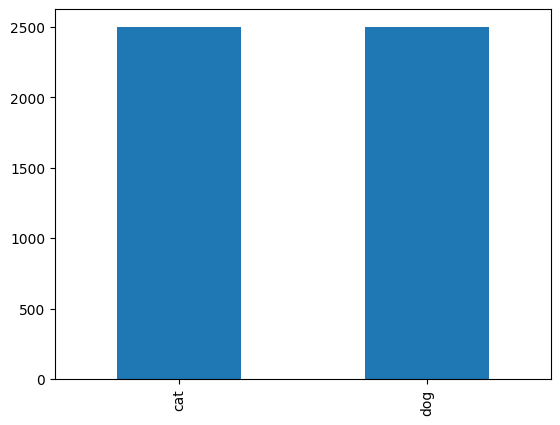

In [11]:
df_train = pd.DataFrame(y_train_img, columns=['category'])
df_train['category'].value_counts().plot.bar()

Como podemos ver tenemos 2500 ejemplos de cada clase... poquito para ser una red neuronal para vision por computador... ya vereis...

## 6. Pintemos una imagen

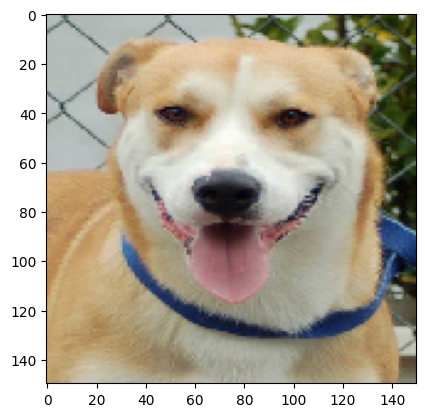

In [18]:
sample = random.choice(range(0,4999))
image = x_train_scaled[sample]
plt.imshow(image, cmap=plt.cm.binary)

## 7. Apilemos bloques para hacer el modelo

<img src="https://i.imgur.com/ebkMGGu.jpg" width="100%"/>

In [19]:
model = ks.Sequential()

model.add(ks.layers.Conv2D(16, (3, 3), activation='relu',
                           input_shape=(ANCHO_IMAGEN, ALTURA_IMAGEN, CANALES_IMAGENES)))
model.add(ks.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(ks.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(ks.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(ks.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(ks.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(ks.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(ks.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(ks.layers.Flatten())
model.add(ks.layers.Dense(512, activation='relu'))
model.add(ks.layers.Dropout(0.3))
model.add(ks.layers.Dense(512, activation='relu'))
model.add(ks.layers.Dropout(0.3))
model.add(ks.layers.Dense(1, activation='sigmoid')) # 1 de salida porque tenemos dos valores posibles 0 o 1 (tras aplicar un label encoder a dog y cat)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        9280      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

## 8. Montemos el optimizador compilando el modelo


In [20]:
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

## 9. Definamos un callback para el Early Stopping

**Early Stopping**

Prevenimos el sobre ajuste parando cuando tras 10 epochs y el error de la validacion no decrementa (estamos en una plateau)

In [21]:
callback_val_loss = EarlyStopping(monitor="val_loss", patience=5)
callback_val_accuracy = EarlyStopping(monitor="val_accuracy", patience=10)

## 10. Preparamos los datos

Haremos un one-hot encoding que nos va a ir bien para nuestra clasificación, porque lo que viene de serie son cadena de texto 'dog' y 'cat'

In [22]:
y_train_img

array(['cat', 'cat', 'cat', ..., 'dog', 'dog', 'dog'], dtype='<U3')

In [23]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y_train_img)
y_train_encoded = le.transform(y_train_img)
y_val_encoded = le.transform(y_val_img)
y_test_encoded = le.transform(y_test_img)

In [24]:
y_train_encoded

array([0, 0, 0, ..., 1, 1, 1])

## 11. Entrenemos el modelo!

In [25]:
epochs = 200

# Este FIT hay que cambiarlo!!

history = model.fit(x_train_scaled, y_train_encoded, epochs=epochs,
                    validation_data=(x_val_scaled, y_val_encoded), batch_size=512,
                    callbacks=[callback_val_loss, callback_val_accuracy])

Epoch 1/200
10/10 [==============================] - 29s 1s/step - loss: 0.7168 - accuracy: 0.4958 - val_loss: 0.6941 - val_accuracy: 0.5000
Epoch 2/200
10/10 [==============================] - 3s 291ms/step - loss: 0.6920 - accuracy: 0.5172 - val_loss: 0.6890 - val_accuracy: 0.6040
Epoch 3/200
10/10 [==============================] - 3s 294ms/step - loss: 0.6842 - accuracy: 0.5708 - val_loss: 0.6742 - val_accuracy: 0.5900
Epoch 4/200
10/10 [==============================] - 3s 314ms/step - loss: 0.6787 - accuracy: 0.5612 - val_loss: 0.6665 - val_accuracy: 0.6230
Epoch 5/200
10/10 [==============================] - 3s 315ms/step - loss: 0.6664 - accuracy: 0.5922 - val_loss: 0.6498 - val_accuracy: 0.6250
Epoch 6/200
10/10 [==============================] - 3s 295ms/step - loss: 0.6494 - accuracy: 0.6188 - val_loss: 0.6463 - val_accuracy: 0.6080
Epoch 7/200
10/10 [==============================] - 3s 291ms/step - loss: 0.6182 - accuracy: 0.6620 - val_loss: 0.6133 - val_accuracy: 0.6710
E

### 12. Guardemos el modelo

In [26]:
model.save(ruta+"model_base.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 13. Veamos los resultados

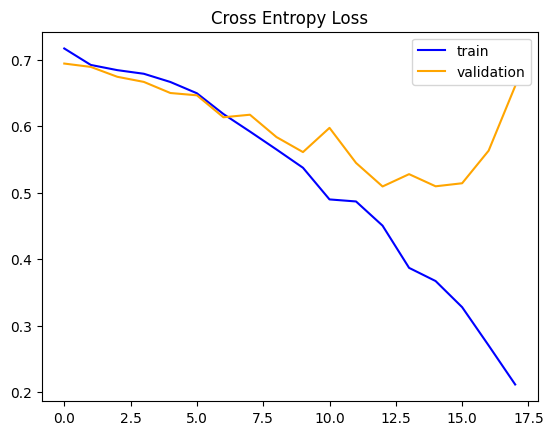

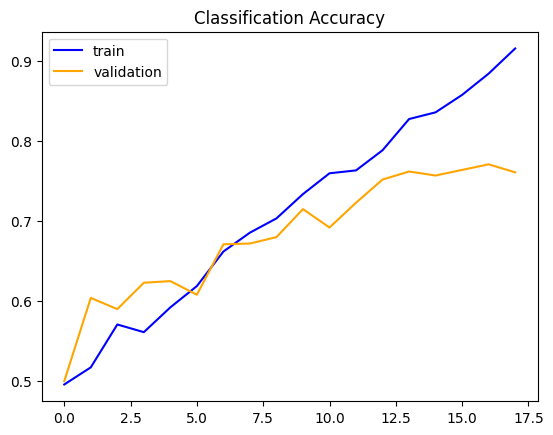

In [27]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='validation')
plt.legend()
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='validation')
plt.legend()
plt.show()

In [28]:
_, acc = model.evaluate(x_test_scaled, y_test_encoded, verbose=0)
print('Test del Modelo Simple > %.3f' % (acc * 100.0))

Test del Modelo Simple > 76.800


## 14. Pintemos algunas predicciones

In [29]:
predictions = model.predict(x_test_scaled)


32/32 [==============================] - 0s 8ms/step


In [30]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  if true_label == 1:
    true_label = 'dog'
  else:
    true_label = 'cat'

  if np.max(predictions_array) > 0.50:
    predicted_label = 'dog'
  else:
    predicted_label = 'cat'

  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(1))
  plt.yticks([])

  if true_label == 1:
    true_label = 'dog'
  else:
    true_label = 'cat'

  if np.max(predictions_array) > 0.50:
    predicted_label = 'dog'
  else:
    predicted_label = 'cat'

  if predicted_label == true_label:
    color_plt = 'blue'
  else:
    color_plt = 'red'

  thisplot = plt.bar(range(1), np.max(predictions_array), color=color_plt)
  plt.ylim([0, 1])


Dibujamos los primeros digitos, con las predicciones y sus valores reales (un total de 20 imagenes, para no abusar de vuestros laptops)

Coloreamos las prediciones correctas en azul y los fallos en rojo

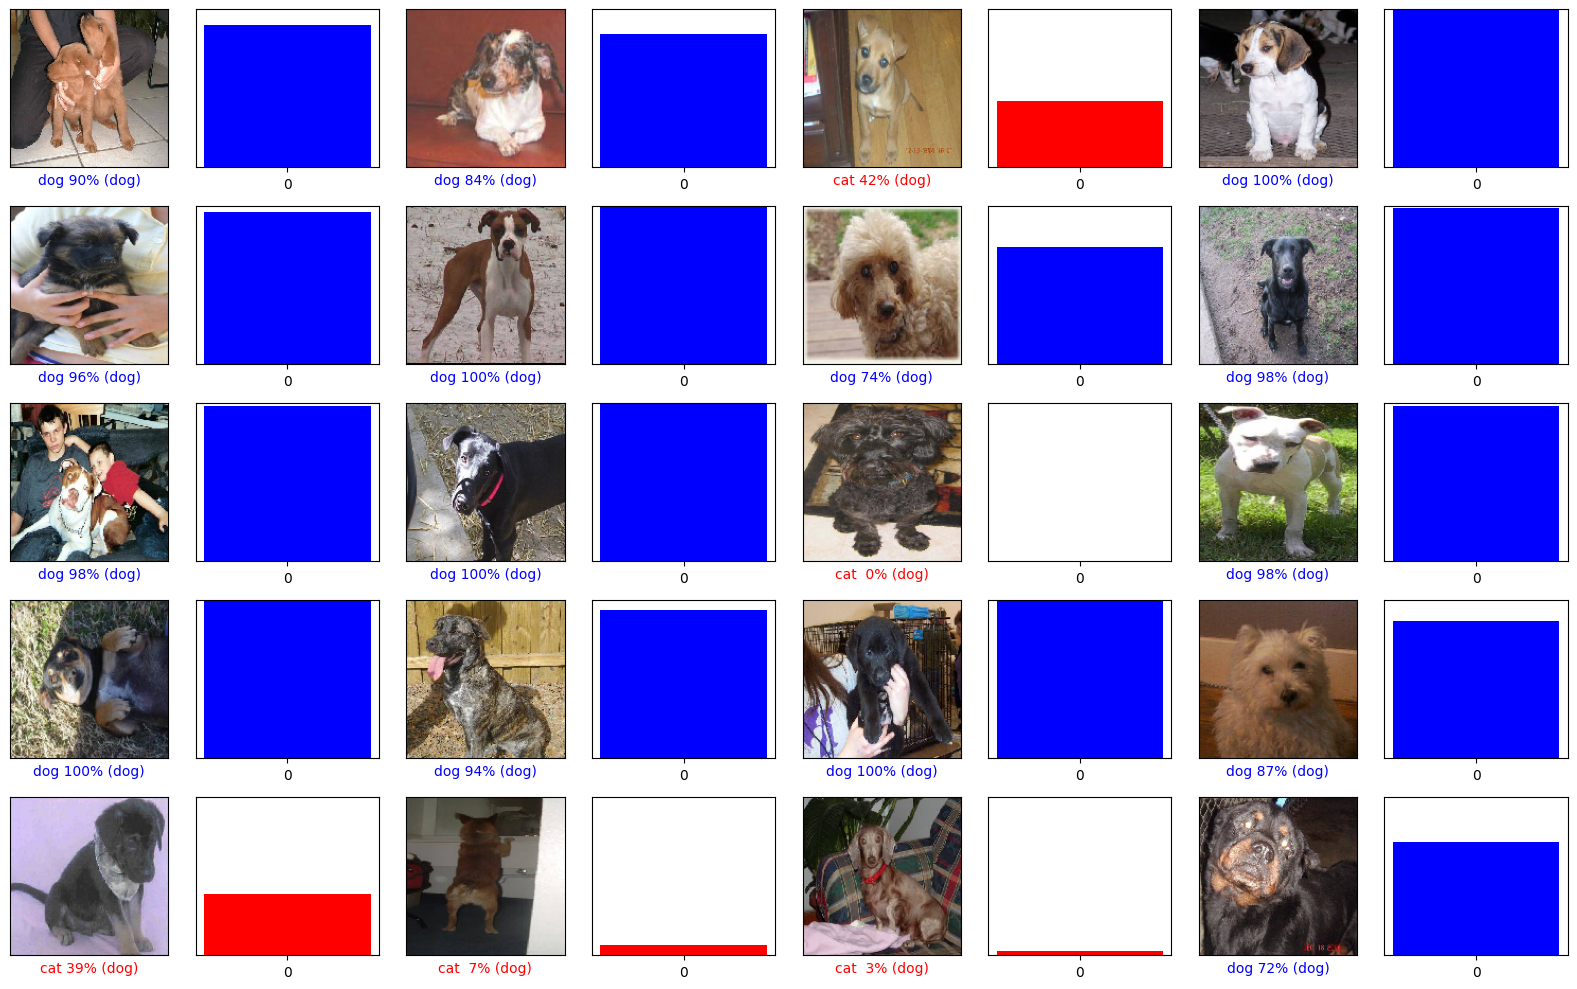

In [31]:
num_rows = 5
num_cols = 4
start = 650
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i+start, predictions[i+start], y_test_encoded, x_test_scaled)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i+start, predictions[i+start], y_test_encoded)
plt.tight_layout()
plt.show()